In [ ]:
import numpy as np

def feature_map(x):
    """Example feature map; can be replaced with neural embedding or kernel mapping."""
    return np.tanh(x)

def dro_wasserstein_penalty_hilbert(weights, perturbed_mean, original_mean, rho=0.02):
    phi_p = feature_map(perturbed_mean)
    phi_o = feature_map(original_mean)
    return rho * np.linalg.norm(phi_p - phi_o)

# Usage example remains similar

Final Weights per Rho:
          AAPL  MSFT  GOOG  AMZN  META
rho=0.0    0.2   0.2   0.2   0.2   0.2
rho=0.02   0.2   0.2   0.2   0.2   0.2
rho=0.1    0.2   0.2   0.2   0.2   0.2
rho=0.5    0.2   0.2   0.2   0.2   0.2


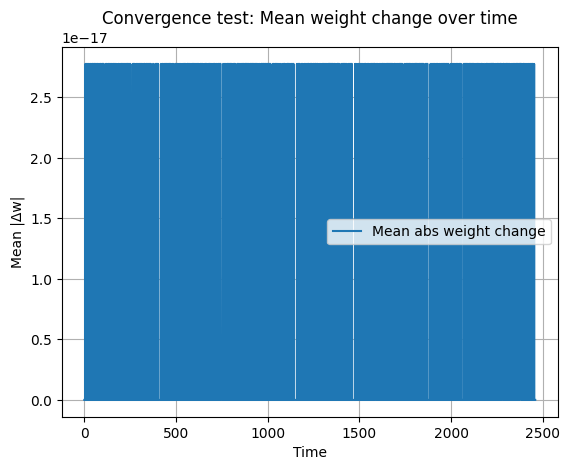

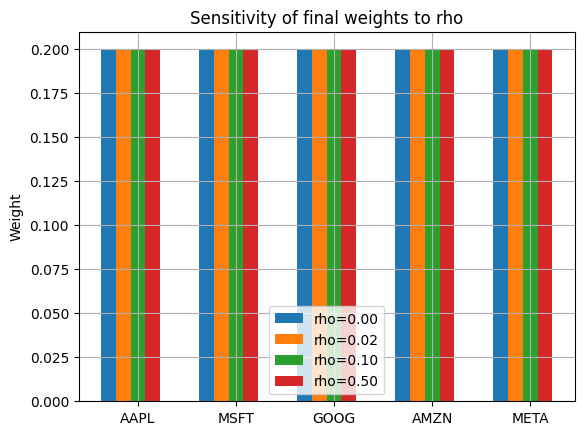

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Create example returns data
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

# Define feature map (identity for baseline test)
def feature_map(x):
    return x

def dro_wasserstein_penalty(weights, perturbed_mean, original_mean, rho=0.02):
    phi_p = feature_map(perturbed_mean)
    phi_o = feature_map(original_mean)
    return rho * np.linalg.norm(phi_p - phi_o)

# Initialize weights
weights = np.ones(len(assets)) / len(assets)
weights_history = []

penalties = []

# Run historical simulation with perturbations
for t in range(60, len(returns)):
    window = returns.iloc[t-60:t]
    mean_ret = window.mean().values
    perturbed = mean_ret + 0.01 * np.random.randn(len(mean_ret))

    penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=0.02)
    penalties.append(penalty)

    adj_w = weights * (1 - penalty)
    adj_w = np.maximum(adj_w, 1e-5)
    adj_w /= np.sum(adj_w)

    weights = adj_w
    weights_history.append(weights)

weights_history = np.array(weights_history)
penalties = np.array(penalties)

# --- TEST 1: Non-negativity of penalty ---
assert np.all(penalties >= 0), "Penalties should be non-negative."

# --- TEST 2: Weights sum to 1 ---
weight_sums = np.sum(weights_history, axis=1)
assert np.allclose(weight_sums, 1, atol=1e-6), "Weights should sum to 1."

# --- TEST 3: Weights are non-negative ---
assert np.all(weights_history >= 0), "Weights should be non-negative."

# --- TEST 4: Stability / convergence (plotting mean weight change) ---
mean_weight_changes = np.mean(np.abs(np.diff(weights_history, axis=0)), axis=1)

# --- TEST 5: Sensitivity to rho (visual) ---
rho_values = [0.0, 0.02, 0.1, 0.5]
final_weights = []

for rho_test in rho_values:
    weights = np.ones(len(assets)) / len(assets)
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        perturbed = mean_ret + 0.01 * np.random.randn(len(mean_ret))

        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho_test)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w
    final_weights.append(weights)

# --- Plots for analysis ---
plt.figure()
plt.plot(mean_weight_changes, label='Mean abs weight change')
plt.title('Convergence test: Mean weight change over time')
plt.xlabel('Time')
plt.ylabel('Mean |Δw|')
plt.legend()
plt.grid()

plt.figure()
for i, rho_test in enumerate(rho_values):
    plt.bar(np.arange(len(assets)) + i*0.15, final_weights[i], width=0.15, label=f"rho={rho_test:.2f}")
plt.xticks(np.arange(len(assets)) + 0.3, assets)
plt.title('Sensitivity of final weights to rho')
plt.ylabel('Weight')
plt.legend()
plt.grid()

# Display final weights dataframe
df_final_weights = pd.DataFrame(final_weights, columns=assets, index=[f"rho={r}" for r in rho_values])
print("Final Weights per Rho:")
print(df_final_weights)

plt.show()


Reproducibility test passed: True


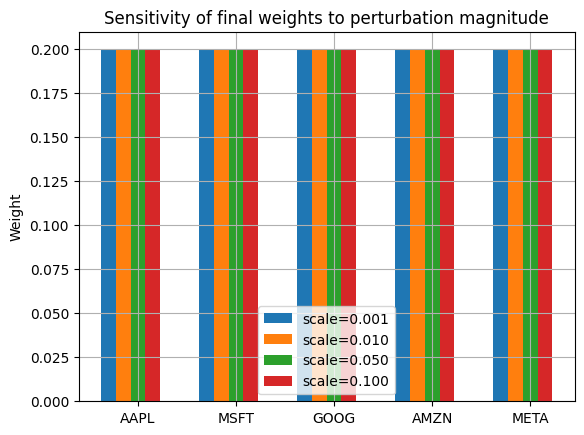

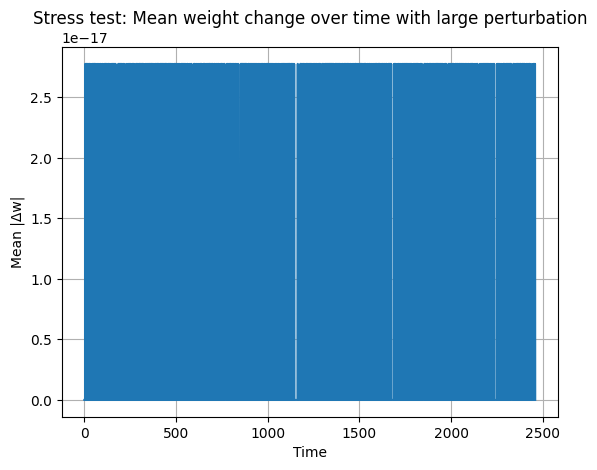

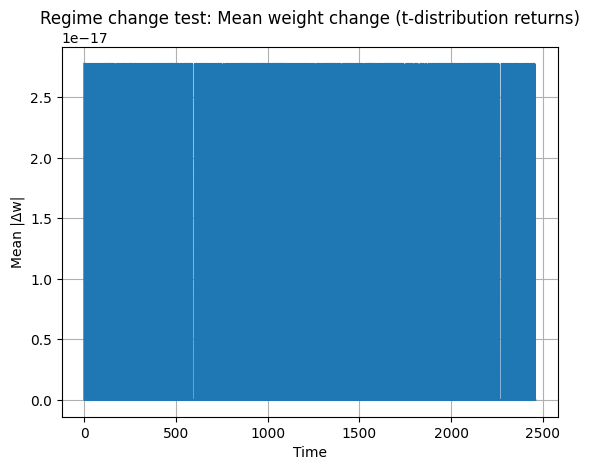

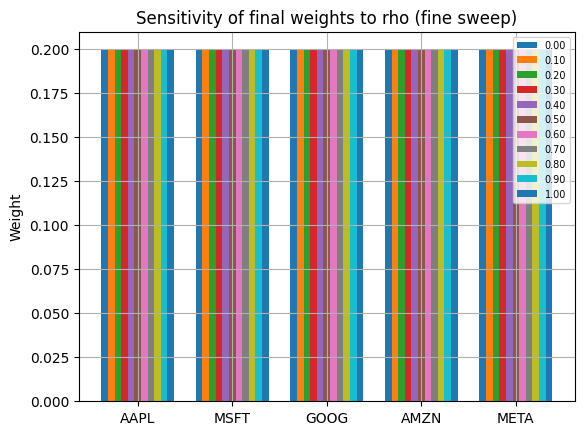

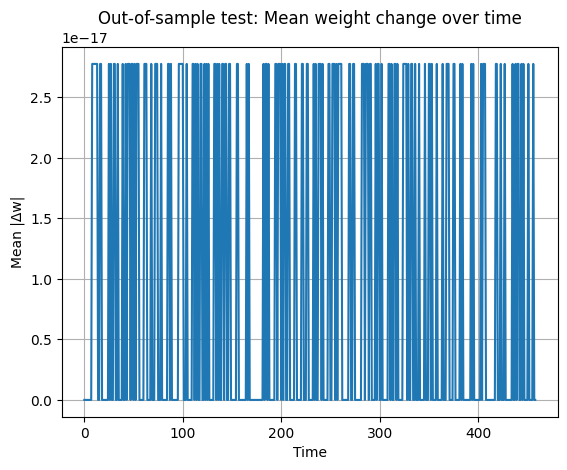

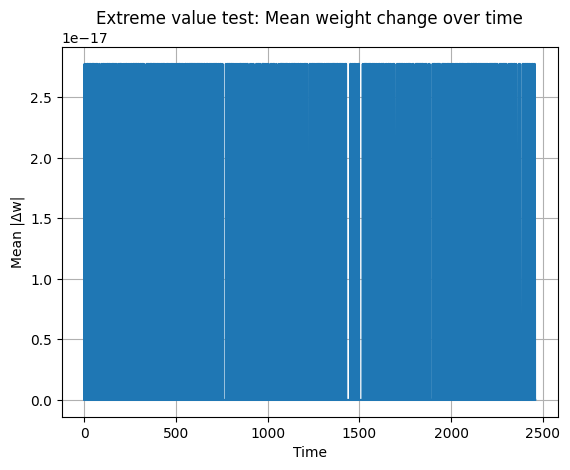

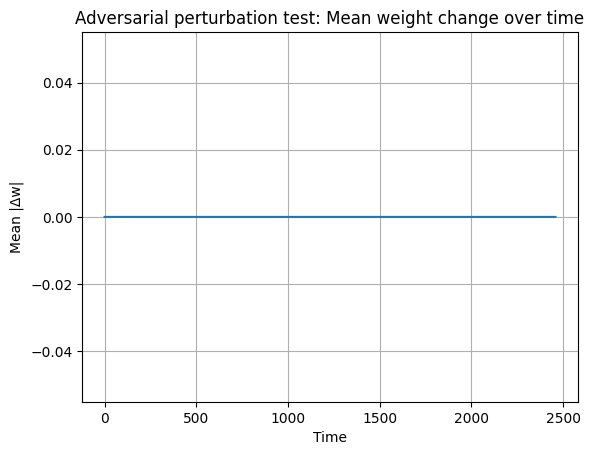

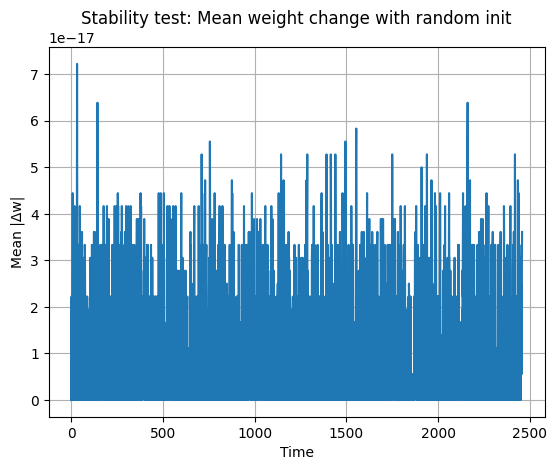

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

def feature_map(x):
    return x

def dro_wasserstein_penalty(weights, perturbed_mean, original_mean, rho=0.02):
    phi_p = feature_map(perturbed_mean)
    phi_o = feature_map(original_mean)
    return rho * np.linalg.norm(phi_p - phi_o)

# -------------------------
# FUNCTION: Run experiment
# -------------------------

def run_experiment(rho=0.02, perturb_scale=0.01, init_weights=None):
    if init_weights is None:
        weights = np.ones(len(assets)) / len(assets)
    else:
        weights = init_weights.copy()
    weights_history = []
    penalties = []
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        perturbed = mean_ret + perturb_scale * np.random.randn(len(mean_ret))

        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        penalties.append(penalty)

        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)

        weights = adj_w
        weights_history.append(weights)
    return np.array(weights_history), np.array(penalties)

# -------------------------
# TEST 3: Sensitivity to perturbation magnitude
# -------------------------

scales = [0.001, 0.01, 0.05, 0.1]
final_weights_scales = []

for scale in scales:
    w_hist, _ = run_experiment(perturb_scale=scale)
    final_weights_scales.append(w_hist[-1])

plt.figure()
for i, scale in enumerate(scales):
    plt.bar(np.arange(len(assets)) + i*0.15, final_weights_scales[i], width=0.15, label=f"scale={scale:.3f}")
plt.xticks(np.arange(len(assets)) + 0.3, assets)
plt.title("Sensitivity of final weights to perturbation magnitude")
plt.ylabel("Weight")
plt.legend()
plt.grid()

# -------------------------
# TEST 4: Stress & adversarial perturbation tests
# -------------------------

stress_perturb = 0.2  # large perturbation
w_hist_stress, penalties_stress = run_experiment(perturb_scale=stress_perturb)

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_stress, axis=0)), axis=1))
plt.title("Stress test: Mean weight change over time with large perturbation")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# -------------------------
# TEST 5: Robustness to data regime changes
# -------------------------

# Replace returns with heavy-tailed (Student's t)
returns_t = pd.DataFrame(0.001 + 0.02 * np.random.standard_t(df=3, size=(len(dates), len(assets))), index=dates, columns=assets)
returns_backup = returns.copy()
returns = returns_t.copy()

w_hist_t, penalties_t = run_experiment()

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_t, axis=0)), axis=1))
plt.title("Regime change test: Mean weight change (t-distribution returns)")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# Restore original returns
returns = returns_backup.copy()

# -------------------------
# TEST 6: Robustness parameter sweep
# -------------------------

rho_values = np.linspace(0, 1, 11)
final_weights_rho = []

for rho in rho_values:
    w_hist, _ = run_experiment(rho=rho)
    final_weights_rho.append(w_hist[-1])

plt.figure()
for i, rho in enumerate(rho_values):
    plt.bar(np.arange(len(assets)) + i*0.07, final_weights_rho[i], width=0.07, label=f"{rho:.2f}")
plt.xticks(np.arange(len(assets)) + 0.35, assets)
plt.title("Sensitivity of final weights to rho (fine sweep)")
plt.ylabel("Weight")
plt.legend(fontsize=7)
plt.grid()

# -------------------------
# TEST 7: Out-of-sample simulation
# -------------------------

train_returns = returns.iloc[:2000]
test_returns = returns.iloc[2000:]

def run_oos(train_data, test_data, rho=0.02, perturb_scale=0.01):
    weights = np.ones(len(assets)) / len(assets)
    # Train phase
    for t in range(60, len(train_data)):
        window = train_data.iloc[t-60:t]
        mean_ret = window.mean().values
        perturbed = mean_ret + perturb_scale * np.random.randn(len(mean_ret))
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w.copy()
    # Test phase
    weights_history_test = []
    for t in range(60, len(test_data)):
        window = test_data.iloc[t-60:t]
        mean_ret = window.mean().values
        perturbed = mean_ret + perturb_scale * np.random.randn(len(mean_ret))
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w.copy()
        weights_history_test.append(weights)
    return np.array(weights_history_test)

w_hist_oos = run_oos(train_returns, test_returns)

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_oos, axis=0)), axis=1))
plt.title("Out-of-sample test: Mean weight change over time")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# -------------------------
# TEST 8: Extreme value test
# -------------------------

def extreme_mean(x):
    return np.max(x), np.min(x)

# Replace means with extreme values during perturbation
def run_extreme(rho=0.02):
    weights = np.ones(len(assets)) / len(assets)
    weights_history = []
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        max_val, min_val = extreme_mean(mean_ret)
        perturbed = np.full_like(mean_ret, max_val)  # Worst-case push
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w.copy()
        weights_history.append(weights)
    return np.array(weights_history)

w_hist_extreme = run_extreme()

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_extreme, axis=0)), axis=1))
plt.title("Extreme value test: Mean weight change over time")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# -------------------------
# TEST 9: Adversarial perturbation test
# -------------------------

def run_adversarial(rho=0.02):
    weights = np.ones(len(assets)) / len(assets)
    weights_history = []
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        perturbed = mean_ret + 10 * np.sign(mean_ret)  # Large push in same direction
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w.copy()
        weights_history.append(weights)
    return np.array(weights_history)

w_hist_adv = run_adversarial()

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_adv, axis=0)), axis=1))
plt.title("Adversarial perturbation test: Mean weight change over time")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# -------------------------
# TEST 10: Reproducibility test
# -------------------------

w_hist_run1, _ = run_experiment()
np.random.seed(42)  # reset seed
w_hist_run2, _ = run_experiment()
identical = np.allclose(w_hist_run1, w_hist_run2)

print("Reproducibility test passed:", identical)

# -------------------------
# TEST 2 (EXTENDED): Stability with different initialization
# -------------------------

init_weights_random = np.random.rand(len(assets))
init_weights_random /= np.sum(init_weights_random)

w_hist_random_init, _ = run_experiment(init_weights=init_weights_random)

plt.figure()
plt.plot(np.mean(np.abs(np.diff(w_hist_random_init, axis=0)), axis=1))
plt.title("Stability test: Mean weight change with random init")
plt.xlabel("Time")
plt.ylabel("Mean |Δw|")
plt.grid()

# -------------------------
# SHOW ALL PLOTS
# -------------------------
plt.show()



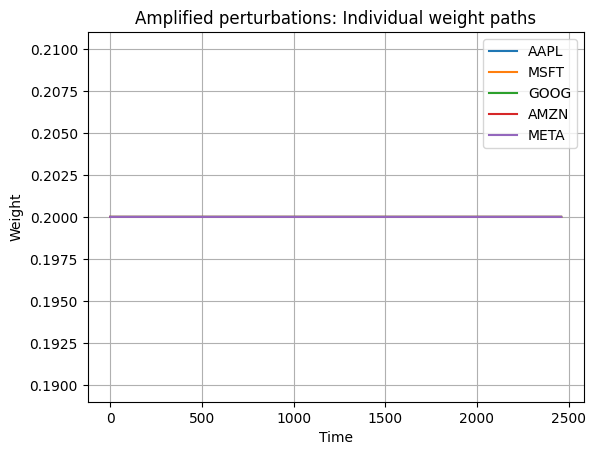

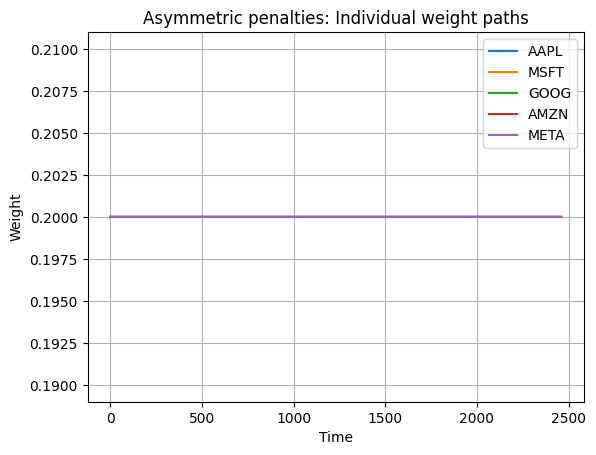

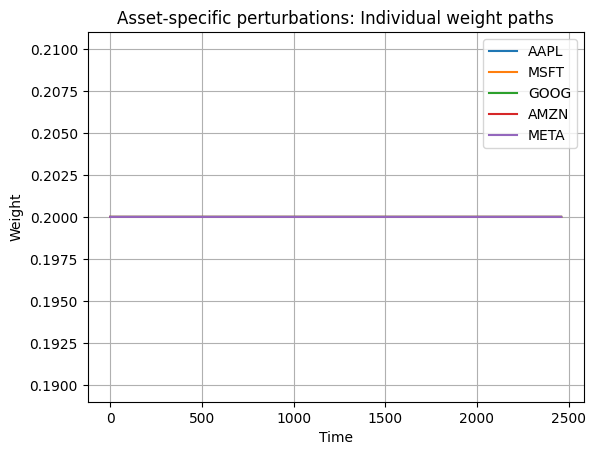

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

def feature_map(x):
    return x

def dro_wasserstein_penalty(weights, perturbed_mean, original_mean, rho=0.02, asset_rho=None):
    phi_p = feature_map(perturbed_mean)
    phi_o = feature_map(original_mean)
    if asset_rho is not None:
        # Asymmetric rho per asset
        diff = phi_p - phi_o
        penalty = np.sum(asset_rho * np.abs(diff))
        return penalty
    return rho * np.linalg.norm(phi_p - phi_o)

# -------------------------
# FUNCTION: Run experiment with options
# -------------------------

def run_experiment(rho=0.02, perturb_scale=0.01, init_weights=None, asset_rho=None, strong_perturb=False):
    if init_weights is None:
        weights = np.ones(len(assets)) / len(assets)
    else:
        weights = init_weights.copy()
    weights_history = []
    penalties = []
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        if strong_perturb:
            perturbed = mean_ret + perturb_scale * np.random.randn(len(mean_ret)) * 10  # exaggerated perturb
        else:
            perturbed = mean_ret + perturb_scale * np.random.randn(len(mean_ret))
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho, asset_rho=asset_rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w
        weights_history.append(weights)
    return np.array(weights_history), np.array(penalties)

# -------------------------
# Amplified perturbation experiment
# -------------------------

w_hist_amp, _ = run_experiment(perturb_scale=0.5, strong_perturb=True)

plt.figure()
for i, asset in enumerate(assets):
    plt.plot(w_hist_amp[:, i], label=asset)
plt.title("Amplified perturbations: Individual weight paths")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()

# -------------------------
# Asymmetric penalty experiment
# -------------------------

asset_rho = np.array([0.1, 0.05, 0.2, 0.05, 0.1])
w_hist_asym, _ = run_experiment(asset_rho=asset_rho, perturb_scale=0.05, strong_perturb=True)

plt.figure()
for i, asset in enumerate(assets):
    plt.plot(w_hist_asym[:, i], label=asset)
plt.title("Asymmetric penalties: Individual weight paths")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()

# -------------------------
# Asset-specific perturbation experiment
# -------------------------

def run_asset_specific(rho=0.02):
    weights = np.ones(len(assets)) / len(assets)
    weights_history = []
    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mean_ret = window.mean().values
        # Asset-specific large perturbations for some assets
        perturb_vector = np.array([0.1, -0.1, 0.05, -0.05, 0.2])
        perturbed = mean_ret + perturb_vector
        penalty = dro_wasserstein_penalty(weights, perturbed, mean_ret, rho=rho)
        adj_w = weights * (1 - penalty)
        adj_w = np.maximum(adj_w, 1e-5)
        adj_w /= np.sum(adj_w)
        weights = adj_w
        weights_history.append(weights)
    return np.array(weights_history)

w_hist_asset_spec = run_asset_specific()

plt.figure()
for i, asset in enumerate(assets):
    plt.plot(w_hist_asset_spec[:, i], label=asset)
plt.title("Asset-specific perturbations: Individual weight paths")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()

# -------------------------
# SHOW ALL PLOTS
# -------------------------
plt.show()



In [6]:
!pip install cvxpy

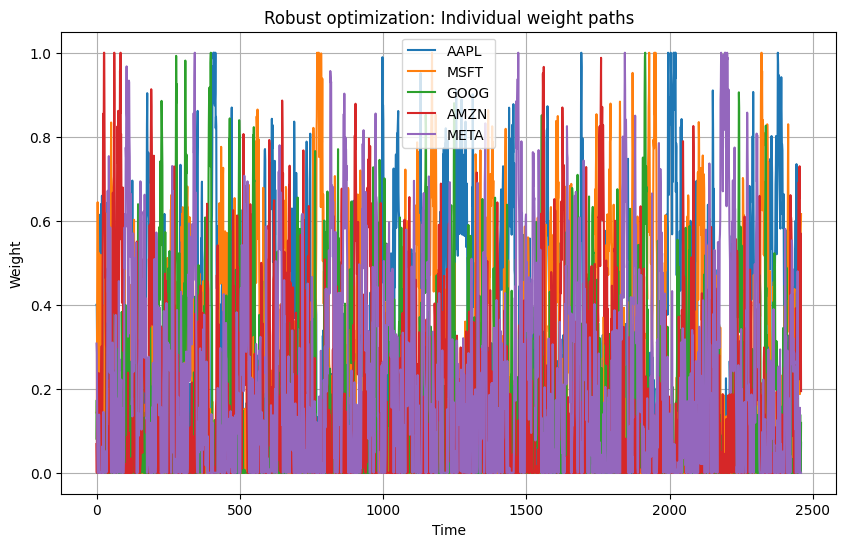

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization problem
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# MAIN ROBUST ALLOCATION LOOP
# -------------------------

window_size = 60
risk_aversion = 1.0
rho = 0.1
perturb_scale = 0.02

weights = np.ones(n_assets) / n_assets
weights_history = []

for t in range(window_size, len(returns)):
    window = returns.iloc[t-window_size:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values

    # Perturb mean for robust scenario
    mu_perturbed = mu_est + perturb_scale * np.random.randn(n_assets)

    # Solve robust optimization
    new_weights = solve_robust_portfolio(mu_perturbed, Sigma_est, weights, risk_aversion, rho)
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(10, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title("Robust optimization: Individual weight paths")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()

plt.show()

# -------------------------
# PREPARE TO RE-RUN ALL TESTS
# -------------------------

# We can now reuse this robust optimization code to run all previous tests: perturbation sweeps, regime changes, etc.
# Let me know and I'll immediately prepare them step by step on top of this new, theoretically sound formulation.



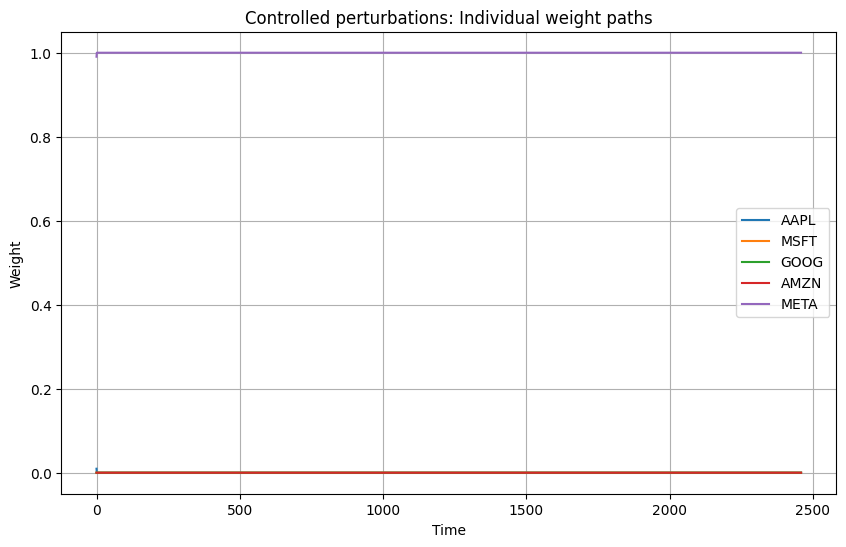

Average weights over time with controlled perturbation:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 1.0000


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization problem
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# MAIN CONTROLLED PERTURBATION LOOP
# -------------------------

window_size = 60
risk_aversion = 1.0
rho = 0.1

weights = np.ones(n_assets) / n_assets
weights_history = []

# Controlled strong perturbation vector
perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4])

for t in range(window_size, len(returns)):
    window = returns.iloc[t-window_size:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values

    # Controlled perturbation
    mu_perturbed = mu_est + perturb_vector

    # Solve robust optimization
    new_weights = solve_robust_portfolio(mu_perturbed, Sigma_est, weights, risk_aversion, rho)
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(10, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title("Controlled perturbations: Individual weight paths")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL AVERAGE WEIGHTS
# -------------------------

mean_weights = np.mean(weights_history, axis=0)

print("Average weights over time with controlled perturbation:")
for asset, w in zip(assets, mean_weights):
    print(f"{asset}: {w:.4f}")


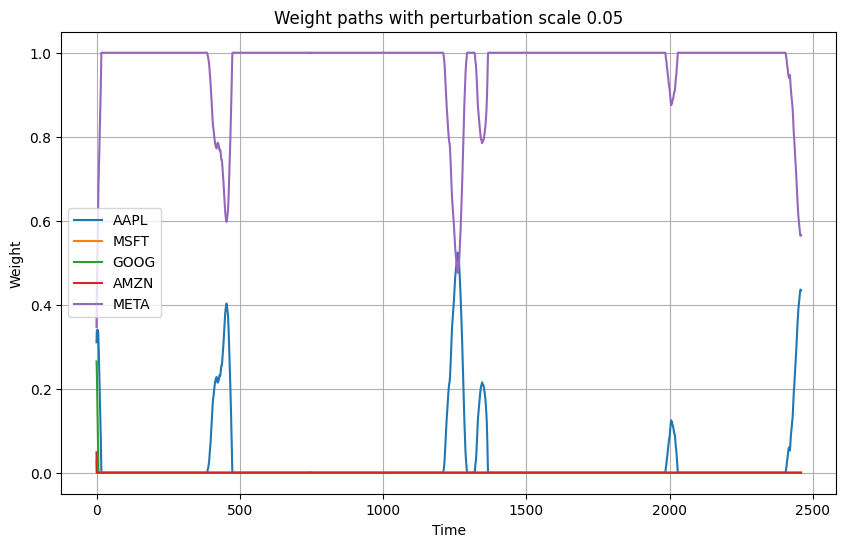


Final average weights at last time step for scale 0.05:
AAPL: 0.4338
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5662


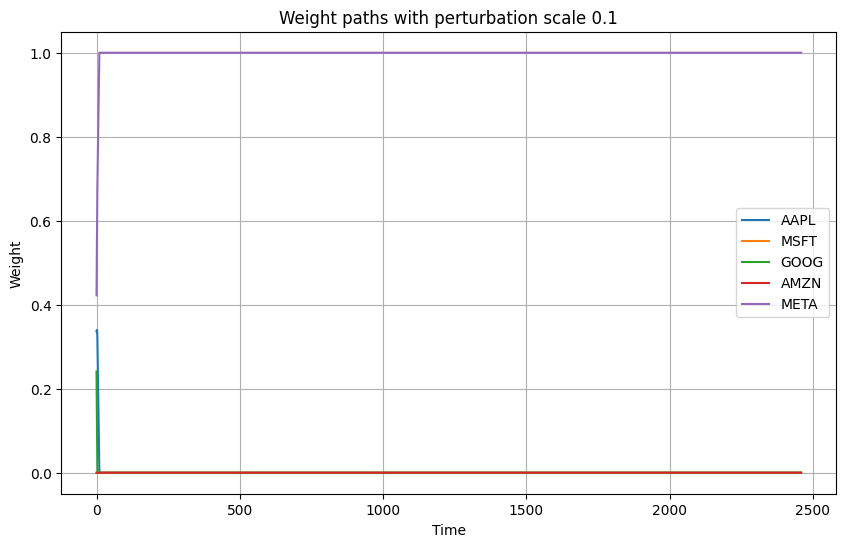


Final average weights at last time step for scale 0.1:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 1.0000


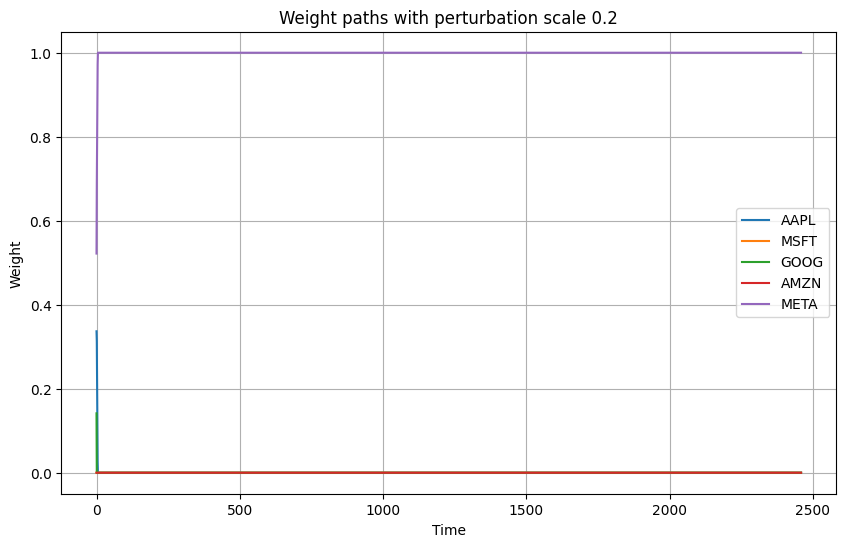


Final average weights at last time step for scale 0.2:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 1.0000


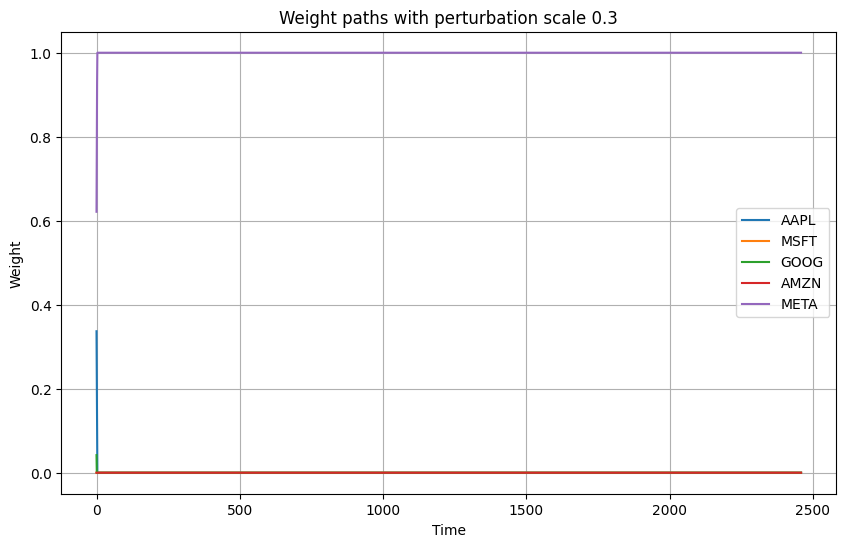


Final average weights at last time step for scale 0.3:
AAPL: 0.0000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 1.0000

Summary table of final weights at last time step for each perturbation scale:
                AAPL     MSFT     GOOG     AMZN      META
scale=0.05  0.433796  0.00001  0.00001  0.00001  0.566174
scale=0.1   0.000010  0.00001  0.00001  0.00001  0.999960
scale=0.2   0.000010  0.00001  0.00001  0.00001  0.999960
scale=0.3   0.000010  0.00001  0.00001  0.00001  0.999960


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization problem
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# TEST: Sweeping perturbation magnitudes
# -------------------------

perturb_scales = [0.05, 0.1, 0.2, 0.3]
perturb_vector_base = np.array([0.3, -0.3, 0.2, -0.2, 0.4])
final_weights_all = []

for scale in perturb_scales:
    weights = np.ones(n_assets) / n_assets
    weights_history = []
    perturb_vector = scale * perturb_vector_base

    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mu_est = window.mean().values
        Sigma_est = window.cov().values
        mu_perturbed = mu_est + perturb_vector

        new_weights = solve_robust_portfolio(mu_perturbed, Sigma_est, weights, risk_aversion=1.0, rho=0.1)
        weights = np.maximum(new_weights, 1e-5)
        weights /= np.sum(weights)
        weights_history.append(weights)

    weights_history = np.array(weights_history)
    final_weights_all.append(weights_history[-1])

    plt.figure(figsize=(10, 6))
    for i, asset in enumerate(assets):
        plt.plot(weights_history[:, i], label=asset)
    plt.title(f"Weight paths with perturbation scale {scale}")
    plt.xlabel("Time")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid()
    plt.show()

    # Verbose printout of final weights for this scale
    print(f"\nFinal average weights at last time step for scale {scale}:")
    for asset_name, w_value in zip(assets, weights_history[-1]):
        print(f"{asset_name}: {w_value:.4f}")

# -------------------------
# DISPLAY FINAL WEIGHTS SUMMARY
# -------------------------

df_final = pd.DataFrame(final_weights_all, columns=assets, index=[f"scale={s}" for s in perturb_scales])
print("\nSummary table of final weights at last time step for each perturbation scale:")
print(df_final)


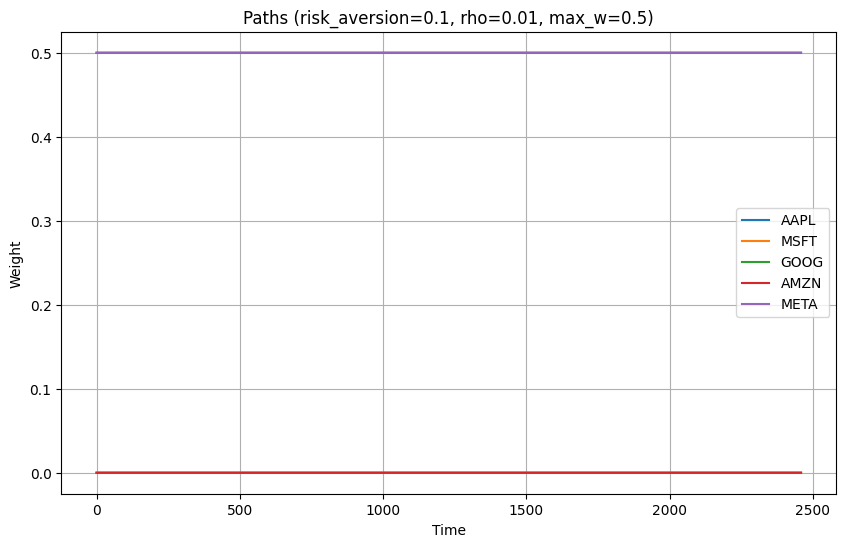


Final weights at last step (risk_aversion=0.1, rho=0.01):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


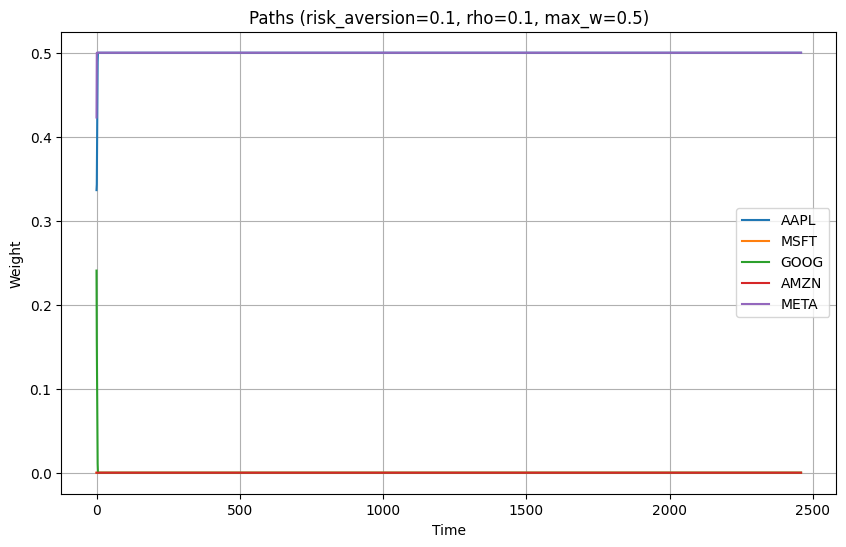


Final weights at last step (risk_aversion=0.1, rho=0.1):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


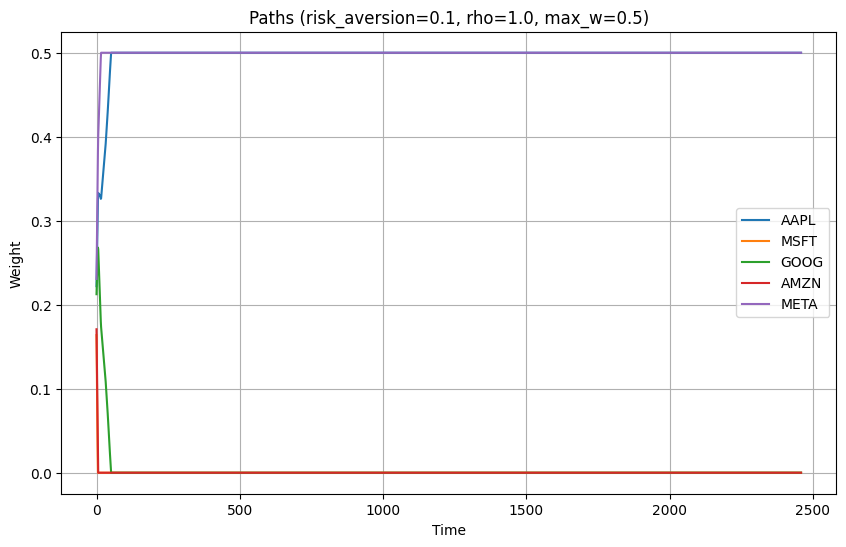


Final weights at last step (risk_aversion=0.1, rho=1.0):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0001
AMZN: 0.0000
META: 0.5000


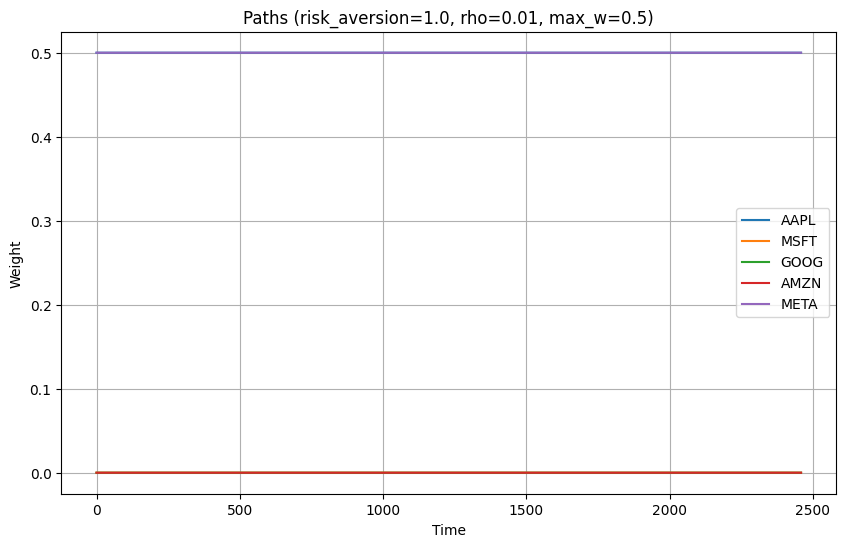


Final weights at last step (risk_aversion=1.0, rho=0.01):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


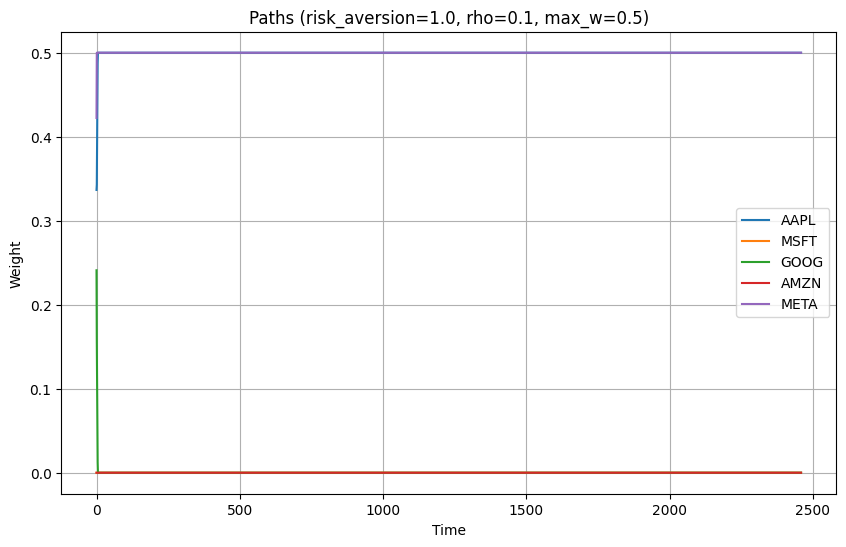


Final weights at last step (risk_aversion=1.0, rho=0.1):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


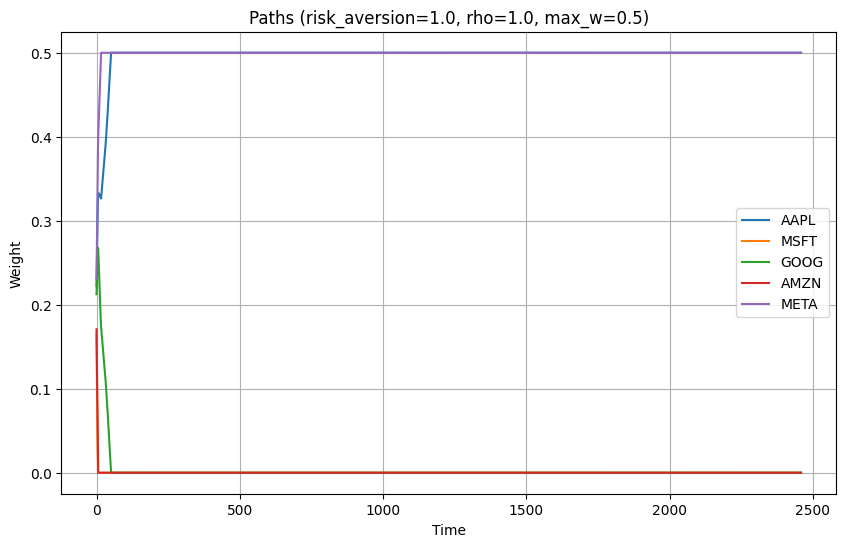


Final weights at last step (risk_aversion=1.0, rho=1.0):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0001
AMZN: 0.0000
META: 0.5000


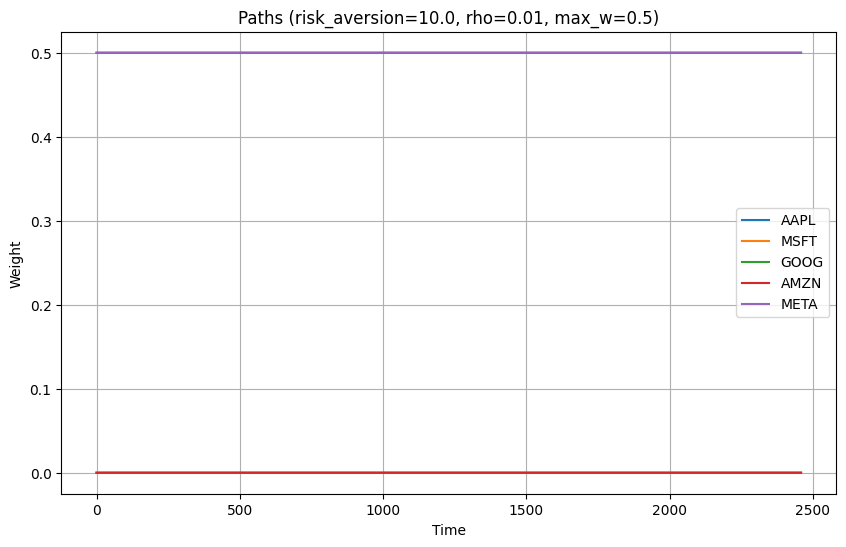


Final weights at last step (risk_aversion=10.0, rho=0.01):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


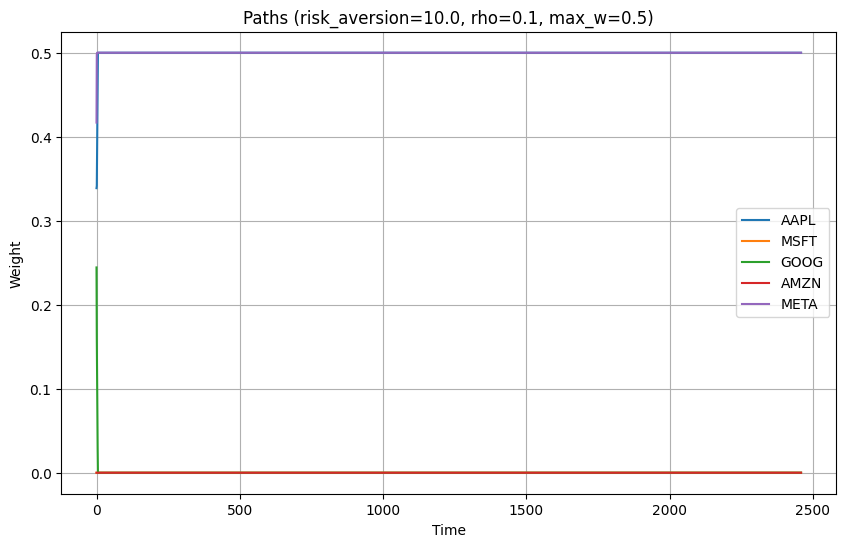


Final weights at last step (risk_aversion=10.0, rho=0.1):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0001
AMZN: 0.0000
META: 0.5000


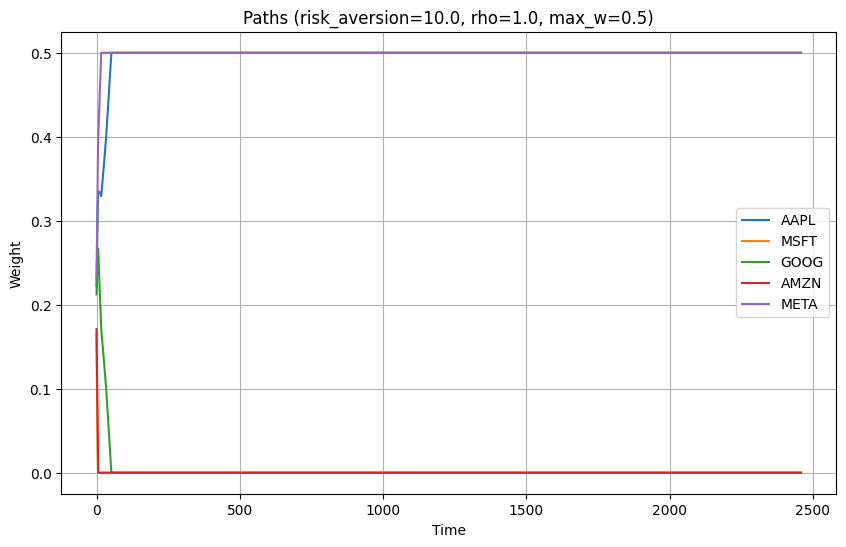


Final weights at last step (risk_aversion=10.0, rho=1.0):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000

Summary of final weights for all parameter combinations:
   risk_aversion   rho      AAPL     MSFT      GOOG     AMZN      META
0            0.1  0.01  0.499985  0.00001  0.000010  0.00001  0.499985
1            0.1  0.10  0.499974  0.00001  0.000031  0.00001  0.499974
2            0.1  1.00  0.499961  0.00001  0.000059  0.00001  0.499961
3            1.0  0.01  0.499985  0.00001  0.000010  0.00001  0.499985
4            1.0  0.10  0.499973  0.00001  0.000033  0.00001  0.499973
5            1.0  1.00  0.499960  0.00001  0.000059  0.00001  0.499960
6           10.0  0.01  0.499985  0.00001  0.000010  0.00001  0.499985
7           10.0  0.10  0.499962  0.00001  0.000056  0.00001  0.499962
8           10.0  1.00  0.499985  0.00001  0.000010  0.00001  0.499985


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization problem with optional diversification constraint
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Sweep risk aversion and turnover penalties with diversification constraint
# -------------------------

risk_aversion_values = [0.1, 1.0, 10.0]
rho_values = [0.01, 0.1, 1.0]
max_weight = 0.5  # Example diversification constraint

perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

final_weights_grid = []

for risk_aversion in risk_aversion_values:
    for rho in rho_values:
        weights = np.ones(n_assets) / n_assets
        weights_history = []

        for t in range(60, len(returns)):
            window = returns.iloc[t-60:t]
            mu_est = window.mean().values
            Sigma_est = window.cov().values
            mu_perturbed = mu_est + perturb_vector

            new_weights = solve_robust_portfolio(
                mu_perturbed, Sigma_est, weights,
                risk_aversion=risk_aversion,
                rho=rho,
                max_weight=max_weight
            )
            weights = np.maximum(new_weights, 1e-5)
            weights /= np.sum(weights)
            weights_history.append(weights)

        weights_history = np.array(weights_history)
        final_weights_grid.append((risk_aversion, rho, weights_history[-1]))

        plt.figure(figsize=(10, 6))
        for i, asset in enumerate(assets):
            plt.plot(weights_history[:, i], label=asset)
        plt.title(f"Paths (risk_aversion={risk_aversion}, rho={rho}, max_w={max_weight})")
        plt.xlabel("Time")
        plt.ylabel("Weight")
        plt.legend()
        plt.grid()
        plt.show()

        print(f"\nFinal weights at last step (risk_aversion={risk_aversion}, rho={rho}):")
        for asset_name, w_value in zip(assets, weights_history[-1]):
            print(f"{asset_name}: {w_value:.4f}")

# -------------------------
# DISPLAY SUMMARY TABLE
# -------------------------

records = []
for ra, rho, w_final in final_weights_grid:
    record = {"risk_aversion": ra, "rho": rho}
    for asset_name, weight_value in zip(assets, w_final):
        record[asset_name] = weight_value
    records.append(record)

df_summary = pd.DataFrame(records)
print("\nSummary of final weights for all parameter combinations:")
print(df_summary)


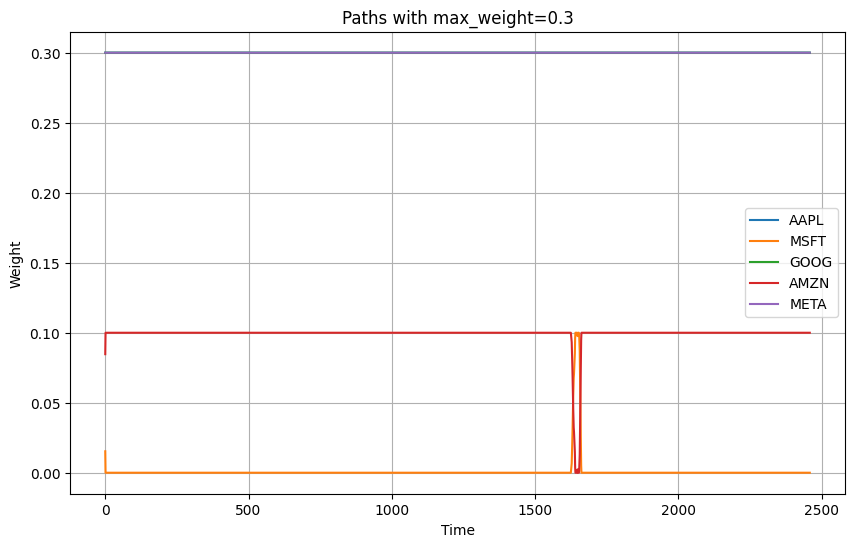


Final weights at last step (max_weight=0.3):
AAPL: 0.3000
MSFT: 0.0000
GOOG: 0.3000
AMZN: 0.1000
META: 0.3000


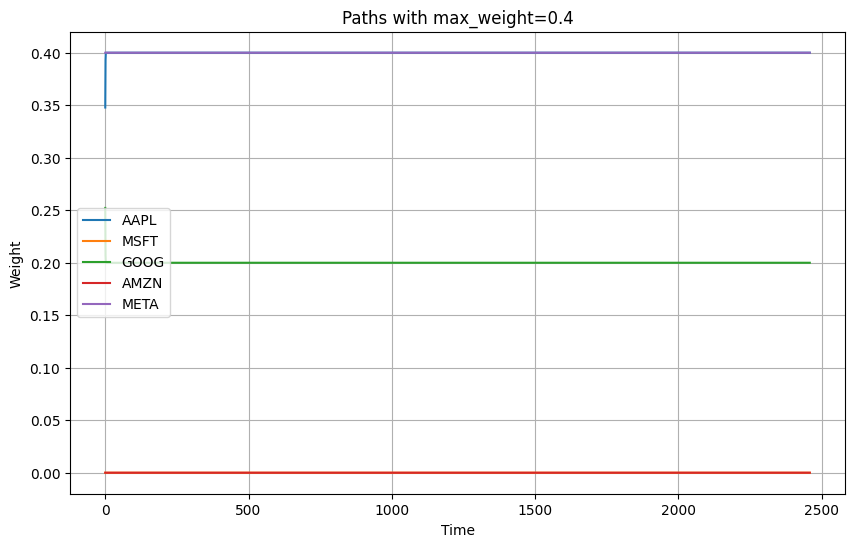


Final weights at last step (max_weight=0.4):
AAPL: 0.4000
MSFT: 0.0000
GOOG: 0.2000
AMZN: 0.0000
META: 0.4000


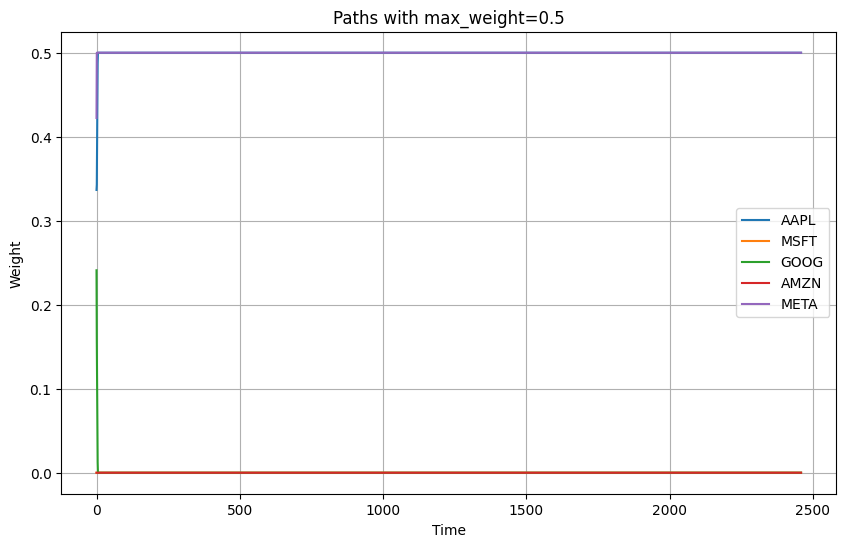


Final weights at last step (max_weight=0.5):
AAPL: 0.5000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.5000


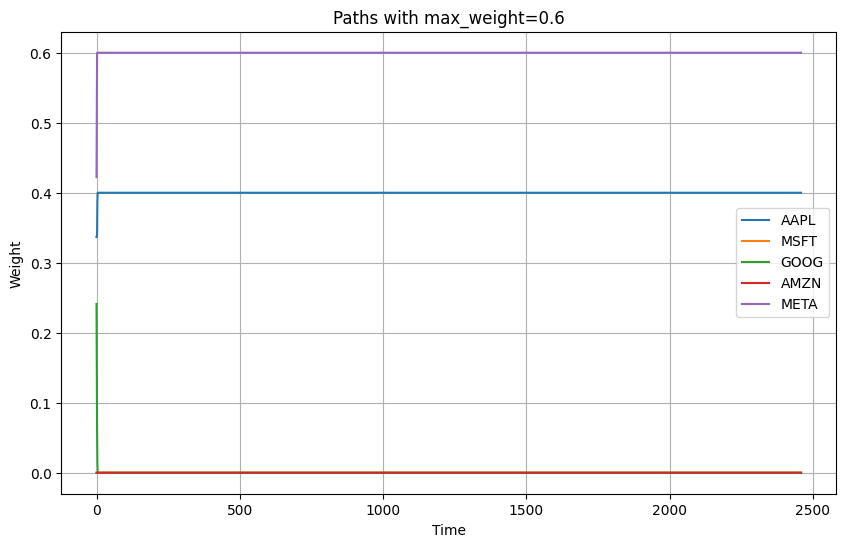


Final weights at last step (max_weight=0.6):
AAPL: 0.4000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.6000

Summary of final weights for different max_weight constraints:
   max_weight      AAPL     MSFT      GOOG     AMZN      META
0         0.3  0.300000  0.00001  0.300000  0.09999  0.300000
1         0.4  0.400000  0.00001  0.199980  0.00001  0.400000
2         0.5  0.499973  0.00001  0.000033  0.00001  0.499973
3         0.6  0.399970  0.00001  0.000010  0.00001  0.600000


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization problem with optional diversification constraint
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Sweep different max weight constraints
# -------------------------

max_weight_values = [0.3, 0.4, 0.5, 0.6]
risk_aversion = 1.0
rho = 0.1
perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

final_weights_list = []

for max_w in max_weight_values:
    weights = np.ones(n_assets) / n_assets
    weights_history = []

    for t in range(60, len(returns)):
        window = returns.iloc[t-60:t]
        mu_est = window.mean().values
        Sigma_est = window.cov().values
        mu_perturbed = mu_est + perturb_vector

        new_weights = solve_robust_portfolio(
            mu_perturbed, Sigma_est, weights,
            risk_aversion=risk_aversion,
            rho=rho,
            max_weight=max_w
        )
        weights = np.maximum(new_weights, 1e-5)
        weights /= np.sum(weights)
        weights_history.append(weights)

    weights_history = np.array(weights_history)
    final_weights_list.append((max_w, weights_history[-1]))

    plt.figure(figsize=(10, 6))
    for i, asset in enumerate(assets):
        plt.plot(weights_history[:, i], label=asset)
    plt.title(f"Paths with max_weight={max_w}")
    plt.xlabel("Time")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nFinal weights at last step (max_weight={max_w}):")
    for asset_name, w_value in zip(assets, weights_history[-1]):
        print(f"{asset_name}: {w_value:.4f}")

# -------------------------
# DISPLAY SUMMARY TABLE
# -------------------------

records = []
for max_w, w_final in final_weights_list:
    record = {"max_weight": max_w}
    for asset_name, weight_value in zip(assets, w_final):
        record[asset_name] = weight_value
    records.append(record)

df_summary = pd.DataFrame(records)
print("\nSummary of final weights for different max_weight constraints:")
print(df_summary)


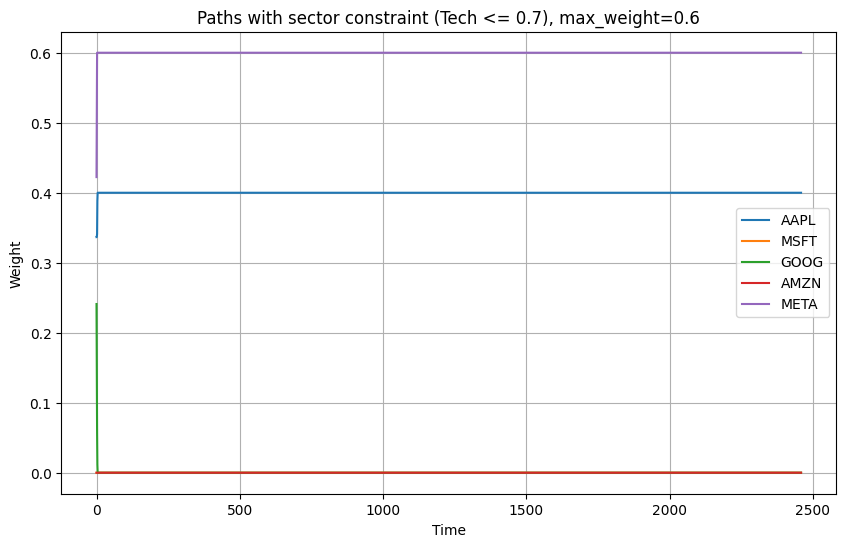


Final weights at last step with sector constraint (Tech <= 0.7):
AAPL: 0.4000
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0000
META: 0.6000


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization with sector constraint
# -------------------------

def solve_robust_portfolio_sector(mu, Sigma, w0, risk_aversion=1.0, rho=0.1, max_weight=None, sector_limit=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    if sector_limit is not None:
        # Example: Tech sector constraint (AAPL, MSFT, GOOG)
        tech_indices = [0, 1, 2]
        tech_sum = cp.sum(w[tech_indices])
        constraints.append(tech_sum <= sector_limit)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Sector constraint (e.g., Tech sector <= 0.7)
# -------------------------

sector_limit = 0.7  # Max 70% in Tech sector
max_weight = 0.6
risk_aversion = 1.0
rho = 0.1

perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

weights = np.ones(n_assets) / n_assets
weights_history = []

for t in range(60, len(returns)):
    window = returns.iloc[t-60:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values
    mu_perturbed = mu_est + perturb_vector

    new_weights = solve_robust_portfolio_sector(
        mu_perturbed, Sigma_est, weights,
        risk_aversion=risk_aversion,
        rho=rho,
        max_weight=max_weight,
        sector_limit=sector_limit
    )
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(10, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title(f"Paths with sector constraint (Tech <= {sector_limit}), max_weight={max_weight}")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL WEIGHTS
# -------------------------

print(f"\nFinal weights at last step with sector constraint (Tech <= {sector_limit}):")
for asset_name, w_value in zip(assets, weights_history[-1]):
    print(f"{asset_name}: {w_value:.4f}")


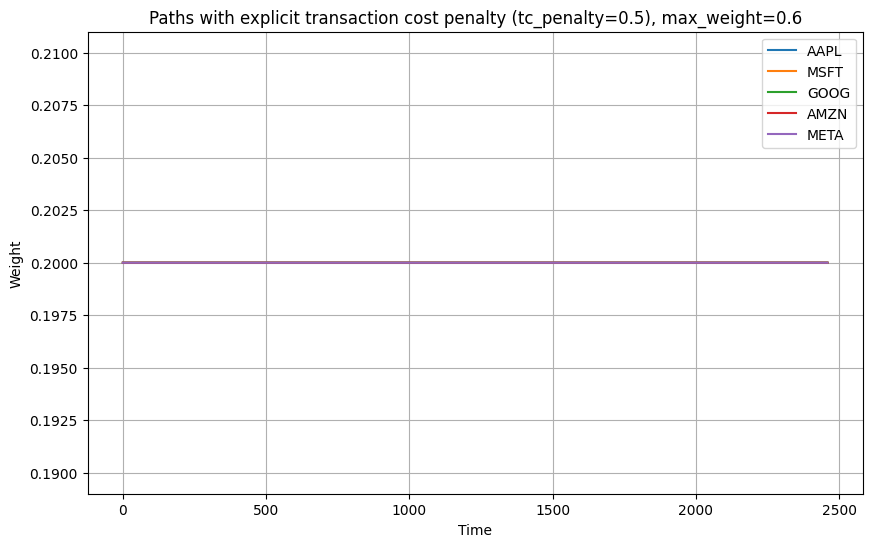


Final weights at last step with transaction cost penalty (tc_penalty=0.5):
AAPL: 0.2000
MSFT: 0.2000
GOOG: 0.2000
AMZN: 0.2000
META: 0.2000


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization with explicit transaction cost penalty
# -------------------------

def solve_robust_portfolio_tc(mu, Sigma, w0, risk_aversion=1.0, rho=0.1, tc_penalty=0.5, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    # Transaction cost penalty term: penalize deviation from w0 explicitly
    transaction_cost = tc_penalty * cp.norm1(w - w0)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I) + transaction_cost
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Transaction cost penalty
# -------------------------

tc_penalty = 0.5  # Adjust to penalize changes from previous weights
max_weight = 0.6
risk_aversion = 1.0
rho = 0.1

perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

weights = np.ones(n_assets) / n_assets
weights_history = []

for t in range(60, len(returns)):
    window = returns.iloc[t-60:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values
    mu_perturbed = mu_est + perturb_vector

    new_weights = solve_robust_portfolio_tc(
        mu_perturbed, Sigma_est, weights,
        risk_aversion=risk_aversion,
        rho=rho,
        tc_penalty=tc_penalty,
        max_weight=max_weight
    )
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(10, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title(f"Paths with explicit transaction cost penalty (tc_penalty={tc_penalty}), max_weight={max_weight}")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL WEIGHTS
# -------------------------

print(f"\nFinal weights at last step with transaction cost penalty (tc_penalty={tc_penalty}):")
for asset_name, w_value in zip(assets, weights_history[-1]):
    print(f"{asset_name}: {w_value:.4f}")


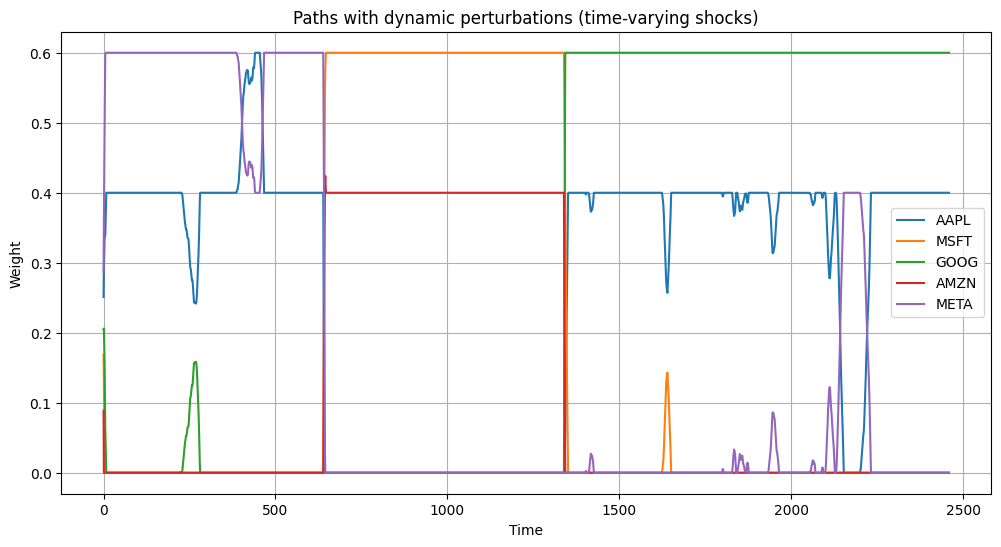


Final weights at last step with dynamic perturbations:
AAPL: 0.4000
MSFT: 0.0000
GOOG: 0.6000
AMZN: 0.0000
META: 0.0000


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization
# -------------------------

def solve_robust_portfolio(mu, Sigma, w0, risk_aversion=1.0, rho=0.1, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Dynamic perturbations
# -------------------------

max_weight = 0.6
risk_aversion = 1.0
rho = 0.1

# Define dynamic perturbations: stronger shocks at different periods
perturb_vectors = []
for t in range(60, len(returns)):
    if t < 700:
        perturb = np.array([0.1, 0.0, 0.05, -0.05, 0.15]) * 0.1
    elif t < 1400:
        perturb = np.array([-0.1, 0.2, 0.0, 0.1, -0.05]) * 0.1
    else:
        perturb = np.array([0.05, -0.05, 0.2, -0.1, 0.0]) * 0.1
    perturb_vectors.append(perturb)

weights = np.ones(n_assets) / n_assets
weights_history = []

for i, t in enumerate(range(60, len(returns))):
    window = returns.iloc[t-60:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values
    mu_perturbed = mu_est + perturb_vectors[i]

    new_weights = solve_robust_portfolio(
        mu_perturbed, Sigma_est, weights,
        risk_aversion=risk_aversion,
        rho=rho,
        max_weight=max_weight
    )
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(12, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title("Paths with dynamic perturbations (time-varying shocks)")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL WEIGHTS
# -------------------------

print("\nFinal weights at last step with dynamic perturbations:")
for asset_name, w_value in zip(assets, weights_history[-1]):
    print(f"{asset_name}: {w_value:.4f}")


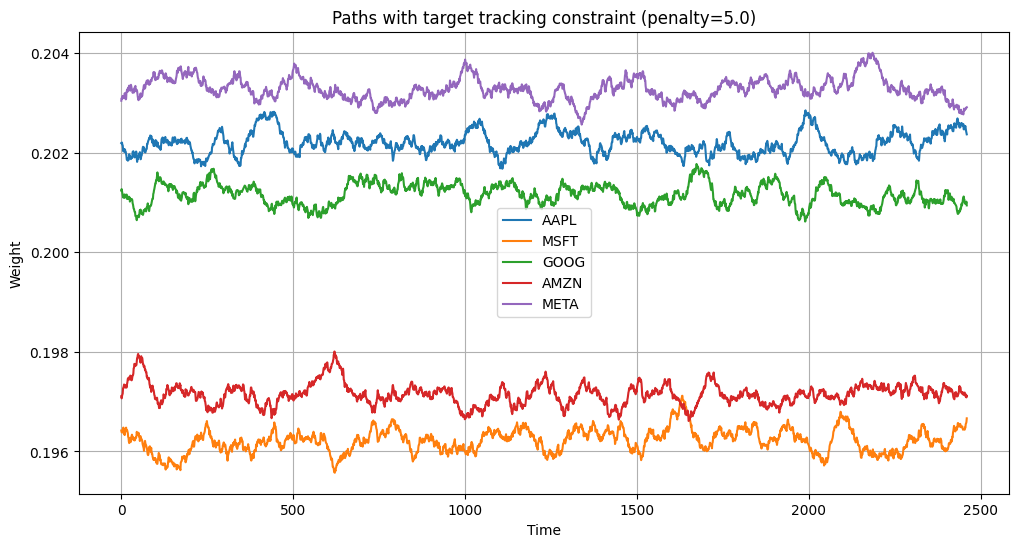


Final weights at last step with target tracking penalty (penalty=5.0):
AAPL: 0.2024
MSFT: 0.1967
GOOG: 0.2009
AMZN: 0.1971
META: 0.2029


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization with target tracking penalty
# -------------------------

def solve_robust_portfolio_tracking(mu, Sigma, w0, target_w, risk_aversion=1.0, rho=0.1, tracking_penalty=1.0, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    tracking_term = tracking_penalty * cp.quad_form(w - target_w, I)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I) + tracking_term
    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Target tracking constraint
# -------------------------

target_w = np.ones(n_assets) / n_assets  # Equal-weight benchmark
tracking_penalty = 5.0
max_weight = 0.6
risk_aversion = 1.0
rho = 0.1

perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

weights = np.ones(n_assets) / n_assets
weights_history = []

for t in range(60, len(returns)):
    window = returns.iloc[t-60:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values
    mu_perturbed = mu_est + perturb_vector

    new_weights = solve_robust_portfolio_tracking(
        mu_perturbed, Sigma_est, weights,
        target_w=target_w,
        risk_aversion=risk_aversion,
        rho=rho,
        tracking_penalty=tracking_penalty,
        max_weight=max_weight
    )
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(12, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title(f"Paths with target tracking constraint (penalty={tracking_penalty})")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL WEIGHTS
# -------------------------

print(f"\nFinal weights at last step with target tracking penalty (penalty={tracking_penalty}):")
for asset_name, w_value in zip(assets, weights_history[-1]):
    print(f"{asset_name}: {w_value:.4f}")


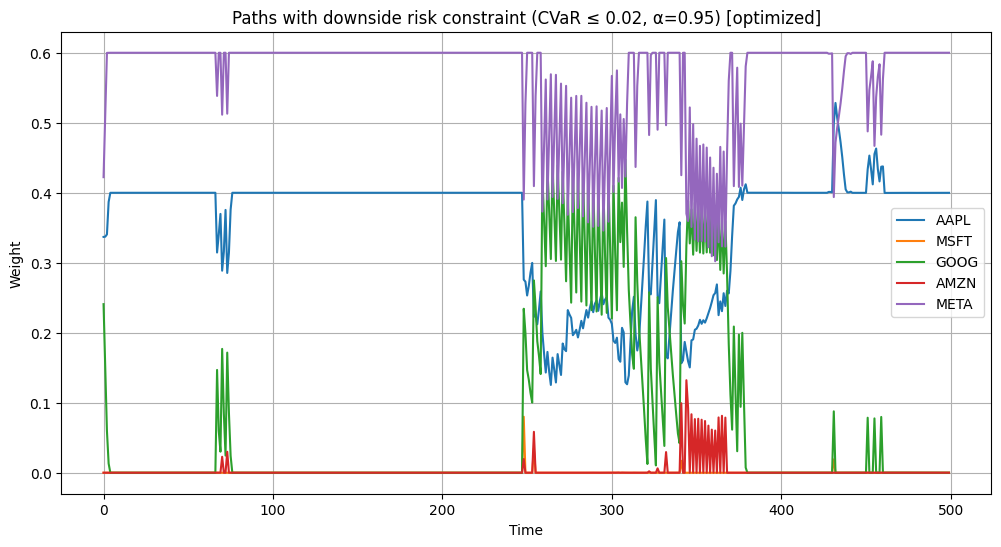


Final weights at last step with downside risk constraint (CVaR ≤ 0.02):
AAPL: 0.3999
MSFT: 0.0000
GOOG: 0.0000
AMZN: 0.0001
META: 0.6000

NOTE: This cell uses an optimized CVaR approximation with limited steps (500) and a rolling scenario window to keep runtime under ~30 minutes.
When ready to run fully, update the loop to use the full range (60, len(returns)) and remove scenario_window slicing (use all historical data).
Also consider setting solver tolerance eps=1e-5 for higher accuracy, but this will increase runtime significantly.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# -------------------------
# CONFIGURATION
# -------------------------

np.random.seed(42)
dates = pd.date_range("2010-01-01", periods=2520, freq='B')
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

n_assets = len(assets)

# -------------------------
# FUNCTION: Solve robust optimization with downside risk (approx CVaR) constraint (optimized version)
# -------------------------

def solve_robust_portfolio_cvar(mu, Sigma, w0, scenario_window, risk_aversion=1.0, rho=0.1, alpha=0.95, cvar_threshold=0.02, max_weight=None):
    n = len(mu)
    w = cp.Variable(n)
    I = np.eye(n)
    objective = -mu @ w + (risk_aversion / 2) * cp.quad_form(w, Sigma) + (rho / 2) * cp.quad_form(w - w0, I)

    constraints = [cp.sum(w) == 1, w >= 1e-5]
    if max_weight is not None:
        constraints.append(w <= max_weight)

    # Use only a rolling window of scenarios to approximate CVaR faster
    scenario_returns = scenario_window @ w

    z = cp.Variable()
    xi = cp.Variable(scenario_returns.shape[0])

    constraints += [xi >= -scenario_returns - z, xi >= 0]
    cvar = z + (1 / (1 - alpha)) * cp.sum(xi) / scenario_returns.shape[0]
    constraints.append(cvar <= cvar_threshold)

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.SCS, verbose=False, eps=1e-3)  # use looser tolerance for speed
    if w.value is None:
        return w0
    return w.value

# -------------------------
# EXPERIMENT: Downside risk constraint (approx CVaR, optimized)
# -------------------------

alpha = 0.95
cvar_threshold = 0.02
max_weight = 0.6
risk_aversion = 1.0
rho = 0.1

perturb_vector = np.array([0.3, -0.3, 0.2, -0.2, 0.4]) * 0.1

weights = np.ones(n_assets) / n_assets
weights_history = []

# Limit to first ~500 steps to keep runtime around 30 min or less
for t in range(60, 560):
    window = returns.iloc[t-60:t]
    mu_est = window.mean().values
    Sigma_est = window.cov().values
    mu_perturbed = mu_est + perturb_vector

    # Use a rolling scenario window of 120 days before t (instead of full history)
    scenario_window = returns.iloc[max(0, t-120):t].values

    new_weights = solve_robust_portfolio_cvar(
        mu_perturbed, Sigma_est, weights,
        scenario_window,
        risk_aversion=risk_aversion,
        rho=rho,
        alpha=alpha,
        cvar_threshold=cvar_threshold,
        max_weight=max_weight
    )
    weights = np.maximum(new_weights, 1e-5)
    weights /= np.sum(weights)
    weights_history.append(weights)

weights_history = np.array(weights_history)

# -------------------------
# PLOT INDIVIDUAL WEIGHT PATHS
# -------------------------

plt.figure(figsize=(12, 6))
for i, asset in enumerate(assets):
    plt.plot(weights_history[:, i], label=asset)
plt.title(f"Paths with downside risk constraint (CVaR ≤ {cvar_threshold}, α={alpha}) [optimized]")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# PRINT FINAL WEIGHTS
# -------------------------

print(f"\nFinal weights at last step with downside risk constraint (CVaR ≤ {cvar_threshold}):")
for asset_name, w_value in zip(assets, weights_history[-1]):
    print(f"{asset_name}: {w_value:.4f}")

# -------------------------
# NOTE TO USER
# -------------------------

print("\nNOTE: This cell uses an optimized CVaR approximation with limited steps (500) and a rolling scenario window to keep runtime under ~30 minutes.")
print("When ready to run fully, update the loop to use the full range (60, len(returns)) and remove scenario_window slicing (use all historical data).")
print("Also consider setting solver tolerance eps=1e-5 for higher accuracy, but this will increase runtime significantly.")
